In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import numpy as np
from PIL import Image
from os.path import join, isfile
from os import listdir
from tensorflow import lite
from keras import layers
from keras.models import Sequential


In [24]:
def zero_pad_num(num, length):
    result_string = num.__str__() + ".jpg"
    pads = length - (math.log(num + 1, 10)).__int__()
    if pads == 0:
        return result_string
    for j in range(pads):
        result_string = "0" + result_string
    return result_string


def crop_images(source_path, destination_path):
    base_path = os.getcwd()

    suit_path = base_path + source_path
    suit_dst = base_path + destination_path
    suit_dims = 5, 58, 35, 95  # left, top, right, bottom

    suit_paths = []
    suit_labels = []

    if not os.path.isdir(suit_dst):
        os.mkdir(suit_dst)

    for path_label in os.listdir(suit_path):
        if os.path.isdir(os.path.join(suit_path, path_label)):
            suit_paths.append(os.path.join(suit_path, path_label))
            suit_labels.append(path_label)

    for index in range(len(suit_paths)):
        path_label = suit_paths[index]
        onlyfiles = [join(path_label, file) for file in listdir(path_label) if
                     isfile(join(path_label, file)) and file != "desktop.ini"]
        for j in range(len(suit_labels)):
            if not os.path.isdir(suit_dst + "\\" + suit_labels[j]):
                os.mkdir(suit_dst + "\\" + suit_labels[j])

        id_length = (math.log(len(onlyfiles), 10)).__int__()
        for j in range(len(onlyfiles)):
            image_to_crop = Image.open(onlyfiles[j])
            image = image_to_crop.crop(suit_dims)
            image.save(join(suit_dst + "\\" + suit_labels[index], zero_pad_num(j, id_length)))
            image_to_crop.close()

In [25]:
crop_images("\\data\\suit", "\\data\\cropped_suit")


In [26]:
batch_size = 16
img_height = 37
img_width = 30

data_dir = os.getcwd() + "\\data\\cropped_suit"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 19711 files belonging to 5 classes.
Using 15769 files for training.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 19711 files belonging to 5 classes.
Using 3942 files for validation.


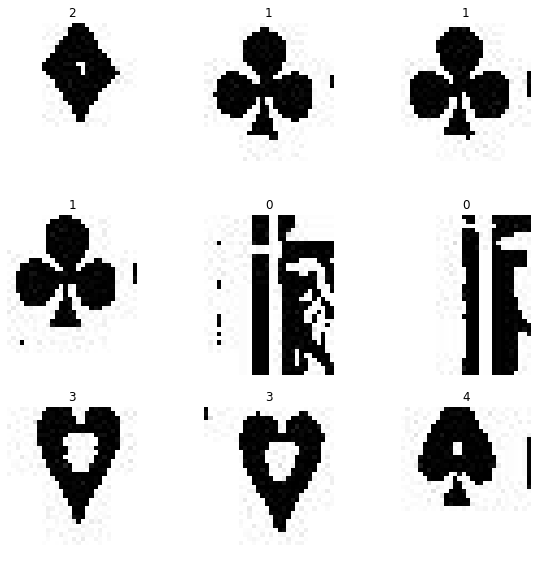

In [28]:
#See if images are there.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [29]:
class_names = ['na', 'clubs', 'diamonds', 'hearts', 'spades']

In [30]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(16, 37, 30, 3)
(16,)


In [31]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [32]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height,
                                            img_width,
                                            3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 37, 30, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 30, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 15, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 7, 64)         

In [35]:
epochs = 4
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/4
986/986 [==============================] - 23s 13ms/step - loss: 0.0849 - accuracy: 0.9685 - val_loss: 0.0069 - val_accuracy: 0.9995
Epoch 2/4
986/986 [==============================] - 9s 9ms/step - loss: 1.3134e-04 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9990
Epoch 3/4
986/986 [==============================] - 9s 10ms/step - loss: 1.8077e-05 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9990
Epoch 4/4
986/986 [==============================] - 9s 9ms/step - loss: 4.3893e-06 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9990


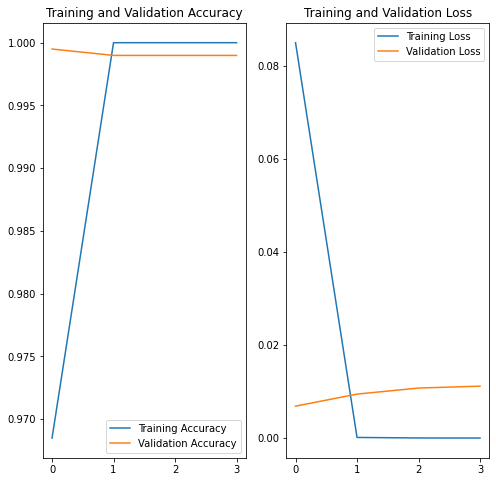

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [39]:
def test_model(mdl):
    test_data = "\\data\\test_images_suit"
    cropped_test_data = "\\data\\test_images_suit_cropped"
    crop_images(test_data, cropped_test_data)
    cropped_test_data = os.getcwd() + cropped_test_data

    paths = []
    path_labels = []

    for path in os.listdir(cropped_test_data):
        if os.path.isdir(os.path.join(cropped_test_data, path)):
            paths.append(os.path.join(cropped_test_data, path))
            path_labels.append(path)

    total_predictions = 0
    total_correct_predictions = 0
    collected_confidences = []

    for index in range(len(paths)):
        correct_predictions = 0
        confidences = []
        path_label = paths[index]
        onlyfiles = [join(path_label, file) for file in listdir(path_label) if
                     isfile(join(path_label, file)) and file != "desktop.ini"]

        for path in onlyfiles:
            img = tf.keras.utils.load_img(
                path, target_size=(img_height, img_width)
            )
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create a batch

            predictions = mdl.predict(img_array)
            score = tf.nn.softmax(predictions[0])
            if np.argmax(score) == index:
                correct_predictions += 1
                total_correct_predictions += 1
                confidences.append(100 * np.max(score))
                collected_confidences.append(100 * np.max(score))
        total_predictions += len(onlyfiles)
        print("{} correct predictions of suit {} out of {} predictions. Ratio: {:.2f}".format(
            correct_predictions,
            path_labels[index],
            len(onlyfiles),
            (correct_predictions.__float__() / len(onlyfiles).__float__())
            )
        )
        print("Confidence statistics on correct prediction ({}):".format(path_labels[index]))
        print("Minimum confidence: {:.2f}".format(np.min(confidences)))
        print("Maximum confidence: {:.2f}".format(np.max(confidences)))
        print("Average confidence: {:.2f}".format(np.average(confidences)))
    print("{} correct predictions of all {} predictions. Ratio: {:.2f}".format(
            total_correct_predictions,
            total_predictions,
            (total_correct_predictions.__float__() / total_predictions.__float__())
            )
        )
    print("Confidence statistics on correct prediction (all ranks):")
    print("Minimum confidence: {:.2f}".format(np.min(collected_confidences)))
    print("Maximum confidence: {:.2f}".format(np.max(collected_confidences)))
    print("Average confidence: {:.2f}".format(np.average(collected_confidences)))
test_model(model)

1 correct predictions of suit backside out of 1 predictions. Ratio: 1.00
Confidence statistics on correct prediction (backside):
Minimum confidence: 100.00
Maximum confidence: 100.00
Average confidence: 100.00
325 correct predictions of suit clubs out of 325 predictions. Ratio: 1.00
Confidence statistics on correct prediction (clubs):
Minimum confidence: 58.93
Maximum confidence: 100.00
Average confidence: 99.86
316 correct predictions of suit diamonds out of 316 predictions. Ratio: 1.00
Confidence statistics on correct prediction (diamonds):
Minimum confidence: 96.21
Maximum confidence: 100.00
Average confidence: 99.98
325 correct predictions of suit hearts out of 325 predictions. Ratio: 1.00
Confidence statistics on correct prediction (hearts):
Minimum confidence: 99.96
Maximum confidence: 100.00
Average confidence: 100.00
324 correct predictions of suit spades out of 325 predictions. Ratio: 1.00
Confidence statistics on correct prediction (spades):
Minimum confidence: 99.94
Maximum 

In [38]:
model.save(os.getcwd() + "\\model\\suit_model")
converter = tf.lite.TFLiteConverter.from_saved_model(os.getcwd() + "\\model\\suit_model")
tflite_model = converter.convert()

with open(os.getcwd() + "\\model\\suit_model\\tflite_suit_model.tflite", 'wb') as f: f.write(tflite_model)

keras_file = os.getcwd() + "\\model\\suit_model\\keras\\suit.h5"
tf.keras.models.save_model(model, keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open(os.getcwd() + "\\model\\suit_model\\keras\\suit.tflite", "wb").write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ablaz\Dropbox\Universitet\DTU\F22\62410-cdio-project\SolitaireCDIO\python\model\suit_model\assets
INFO:tensorflow:Assets written to: C:\Users\ablaz\AppData\Local\Temp\tmpevl24yv2\assets


494196